补充一点Linear实例

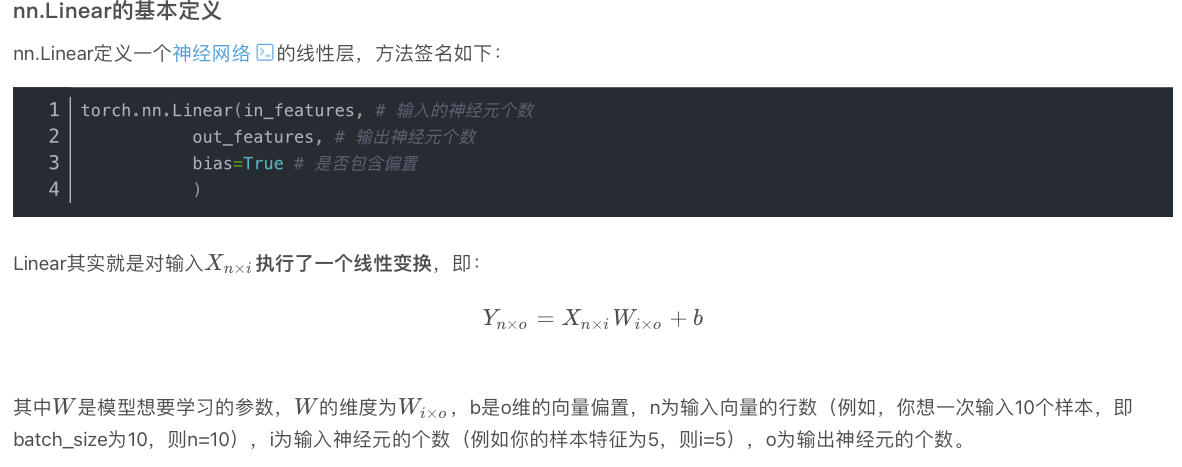

In [12]:
from torch import nn
import torch

model = nn.Linear(2, 1) # 输入特征数为2，输出特征数为1
x = torch.arange(12,dtype=torch.float32).reshape(6,2)
y = model(x)
y

tensor([[0.1747],
        [0.3047],
        [0.4346],
        [0.5645],
        [0.6945],
        [0.8244]], grad_fn=<AddmmBackward0>)

# 代码+笔记📒

## <font color=red>参数管理

In [9]:
import torch 
from torch import nn

# 单隐藏层的多层感知机
net=nn.Sequential(nn.Linear(4,8),nn.ReLU(),nn.Linear(8,1))
X = torch.rand(size=(2,4))  # torch.rand 是该库中用于生成随机张量（Tensor）的函数
net(X)

tensor([[-0.0748],
        [ 0.1379]], grad_fn=<AddmmBackward0>)

- 当通过Sequential类定义模型时， 我们可以通过索引来访问模型的任意层


In [15]:
##  net[2] 对应的是 nn.Sequential 里的第三个元素，也就是最后一个线性层 nn.Linear(8, 1) 。
print(net[2].state_dict()) # state_dict返回包含该模块所有可学习参数

OrderedDict([('weight', tensor([[-0.2391, -0.0974,  0.1215,  0.2145,  0.2299, -0.1440, -0.2382, -0.2666]])), ('bias', tensor([0.0753]))])


- 每个参数都表示为参数类的一个实例

In [23]:
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)
# 访问每个参数的梯度
print(net[2].weight.grad ) #由于我们还没有调用反向传播，所以参数的梯度处于初始状态None

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([0.0753], requires_grad=True)
tensor([0.0753])
None


- 参数初始化
    - 深度学习框架提供默认随机初始化
    - PyTorch的nn.init模块提供了多种预置初始化方法。以下展示自定义初始化方法:

In [31]:
# 将所有权重参数初始化为标准差为0.01的高斯随机变量，且将偏置参数设置为0。
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,mean=0,std=0.01)
        nn.init.zeros_(m.bias)
        
net.apply(init_normal)
net[2].state_dict()

OrderedDict([('weight',
              tensor([[ 0.0012, -0.0141,  0.0059, -0.0026,  0.0127,  0.0010,  0.0107, -0.0054]])),
             ('bias', tensor([0.]))])

In [34]:
# 还可以对某些块应用不同的初始化方法。 
#例如，下面我们使用Xavier初始化方法初始化第一个神经网络层， 然后将第三个神经网络层初始化为常量值42。
def init_xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight,42)

net[0].apply(init_xavier)
net[2].apply(init_42)
print(net.state_dict())

OrderedDict([('0.weight', tensor([[ 0.1032,  0.5768, -0.2508,  0.5595],
        [ 0.1286, -0.3201,  0.0965, -0.1062],
        [ 0.0482, -0.1221,  0.4330,  0.1732],
        [ 0.5237, -0.6950,  0.1669, -0.4073],
        [-0.0008, -0.0585, -0.6367, -0.5588],
        [-0.7031,  0.2383, -0.5311,  0.0712],
        [-0.6335,  0.6354,  0.5645,  0.6467],
        [-0.6686,  0.5655, -0.6918,  0.5639]])), ('0.bias', tensor([0., 0., 0., 0., 0., 0., 0., 0.])), ('2.weight', tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])), ('2.bias', tensor([0.]))])


- 参数绑定：多个层间共享参数
    - 共享参数通常可以节省内存

In [37]:
# 需要先给共享层一个名称，以便后续引用
shared = nn.Linear(8,8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(8, 1))
net(X)
print(net[2].weight.data == net[4].weight.data)

tensor([[True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True]])


##  <font color=red>层和块

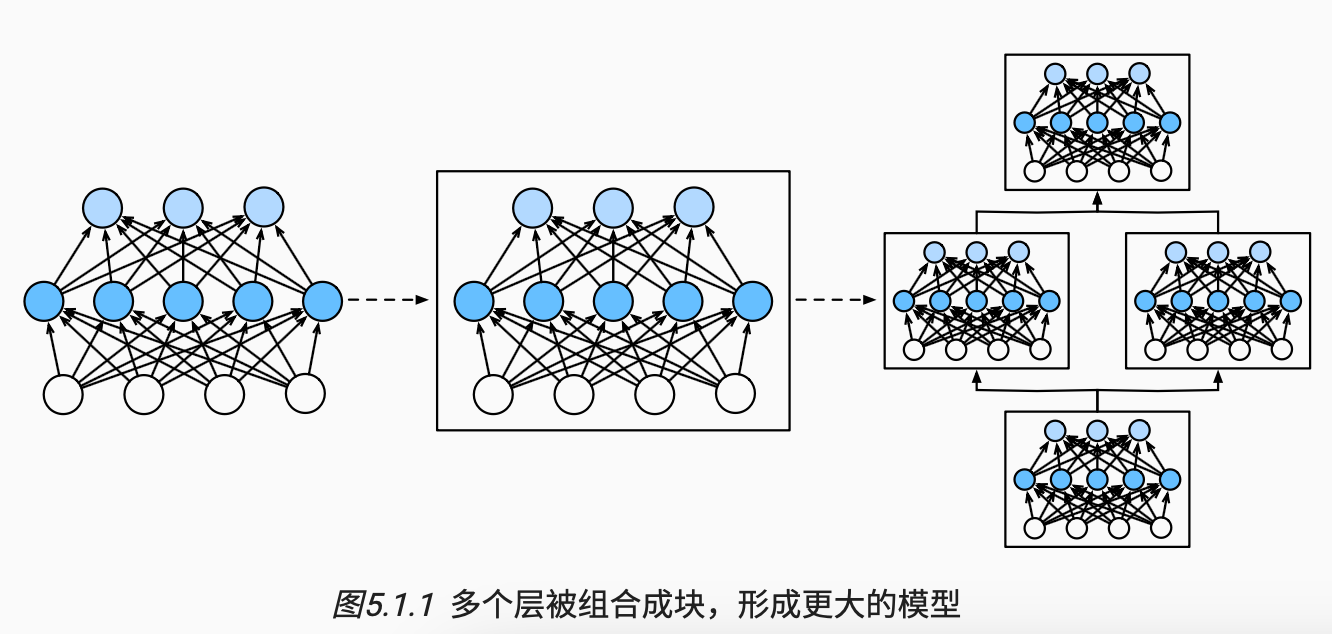
-  块（block）可以描述单个层、由多个层组成的组件或整个模型本身。 使用块进行抽象的一个好处是可以将一些块组合成更大的组件， 这一过程通常是递归的
- 从编程的角度来看，块由类（class）表示。 它的任何子类都必须定义一个将其输入转换为输出的前向传播函数， 并且必须存储任何必需的参数。
- 在定义我们自己的块时，由于自动微分提供了一些后端实现，我们只需要考虑前向传播函数和必需的参数。

⚠️ 其他需注意的：
- 我们一直在通过net(X)调用我们的模型来获得模型的输出。 这实际上是net.__call__(X)的简写。 这个前向传播函数非常简单： 它将列表中的每个块连接在一起，将每个块的输出作为下一个块的输入。

In [45]:
import torch
from torch import nn
from torch.nn import functional as F

# 通过实例化nn.Sequential来构建我们的模型， 层的执行顺序是作为参数传递的。 
## 简而言之，nn.Sequential定义了一种特殊的Module， 即在PyTorch中表示一个块的类， 它维护了一个由Module组成的有序列表。
net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

X = torch.rand(2, 20)
net(X)

tensor([[-0.1463, -0.0523, -0.0399, -0.0341,  0.2250, -0.2048,  0.1361,  0.0305,
         -0.0399, -0.1193],
        [-0.0935,  0.0048,  0.1157, -0.0136,  0.2434, -0.1782,  0.1110, -0.0672,
         -0.0538, -0.0206]], grad_fn=<AddmmBackward0>)

In [42]:
# 从零开始编写一个块：多层感知机
class MLP(nn.Module): # 继承：MLP 类继承自 nn.Module 类
    # 当创建类的一个实例时，init方法会被自动调用，主要用于初始化操作
    def __init__(self): 
        super().__init__()
        self.hidden = nn.Linear(20,256)
        self.out = nn.Linear(256,10) 
    
    def forward(self,X):
        return self.out(F.relu(self.hidden(X)))

net = MLP()
X = torch.rand(2, 20)
net(X)

tensor([[ 0.0836,  0.0467,  0.1723, -0.1054,  0.0813,  0.0894, -0.1220,  0.3699,
         -0.1107, -0.0209],
        [ 0.1200, -0.1070,  0.2367, -0.1366,  0.2150,  0.1253, -0.0109,  0.4951,
         -0.1753,  0.0057]], grad_fn=<AddmmBackward0>)

## <font color=red> 自定义层

- 首先定义一个不带参数的层

In [48]:
import torch
import torch.nn.functional as F
from torch import nn

class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self,X):
        return X - X.mean()
    
layer = CenteredLayer()
layer(torch.FloatTensor([1, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

In [49]:
# 将定义的层组合到更复杂的模型中
net = nn.Sequential(nn.Linear(8, 128), CenteredLayer())

tensor([-2., -1.,  0.,  1.,  2.])

- 带参数的层
    - 全连接层需要两个参数：权重和偏置项。都是用nn.Parameter类定义的！
    - in_units 是输入维度；units 输出维度，代表经过这个自定义线性层的线性变换和激活函数处理后输出的特征数量维度
    

In [57]:
class MyLinear(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, units))
        self.bias = nn.Parameter(torch.randn(units,))
    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)
    
linear = MyLinear(5, 3)
# 使用自定义层直接执行前向传播计算
linear(torch.rand(2,5))  # 2表示批量大小，也就是一次输入的样本数量；5是输入特征维度

tensor([[0.0000, 0.0000, 1.7139],
        [0.0000, 0.0000, 1.4004]])

In [58]:
# 使用自定义层构建模型
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

tensor([[7.8451],
        [0.0000]])

## <font color=red> 读写文件

有时我们希望保存训练的模型， 以备将来在各种环境中使用（比如在部署中进行预测）。 此外，当运行一个耗时较长的训练过程时， 最佳的做法是定期保存中间结果， 以确保在服务器电源被不小心断掉时，我们不会损失几天的计算结果。 因此，现在是时候学习如何加载和存储权重向量和整个模型了。

- 对于单个张量，我们可以直接调用load和save函数分别读写它们。 这两个函数都要求我们提供一个名称，save要求将要保存的变量作为输入。

In [60]:
import torch
from torch import nn
from torch.nn import functional as F

x = torch.arange(4)
torch.save(x, 'x-file')
x2 = torch.load('x-file')
x2

tensor([0, 1, 2, 3])

-  加载和保存模型参数

In [64]:
# 先构造一个多层感知机网络
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20,256)
        self.output = nn.Linear(256,10)
    def forward(self,x):
        return self.output(F.relu(self.hidden(x)))
    
net = MLP()
x = torch.rand(size=(4,20))
y = net(x)

In [71]:
# 将模型参数存储在'data/mlp.params'文件中
import os
if not os.path.exists('data'):
    os.mkdir('data')
torch.save(net.state_dict(), 'data/mlp.params')

In [76]:
# 恢复模型
clone = MLP()
clone.load_state_dict(torch.load('data/mlp.params'))
clone.eval()

MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

💡 补充一个知识点  
- 训练模式（train模式）：在训练过程中，模型的目标是学习数据中的模式，以最小化损失函数。为了防止过拟合和提高模型的泛化能力，一些层会有特定的训练行为。例如，nn.Dropout层会在训练时按照设定的概率随机将一些神经元的输出设置为 0
- 评估模式（eval模式）：当模型用于评估（如在验证集或测试集上计算准确率、损失等指标）或进行预测时，不需要这些训练时的随机化或基于批次的操作。例如，在评估时，Dropout层应该是关闭的，即所有神经元都正常工作，将所有神经元的输出都传递下去；

In [80]:
# 由于两个实例具有相同的模型参数，在输入相同的X时， 两个实例的计算结果应该相同
Y_clone = clone(x)
Y_clone == y

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])